In [1]:
%pylab
%matplotlib inline
import skimage as sk
import skimage.io
import skvideo
import skvideo.io
import torch
import torch as T
import scipy
from torch.autograd import Variable
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.preprocessing import normalize
import torchvision as tv
from tqdm import tqdm
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
import skimage.transform
from importlib import reload
import fish_track as ft

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
reload(ft)

<module 'fish_track' from '/home/ubuntu/fish_track.py'>

In [3]:
directory = "/home/ubuntu/"
# filename = "20180410_1.mp4"
filename = "20180109_2.mp4"
vid_file = directory+filename

In [4]:
firstFrame = ft.get_first_frame(vid_file)

In [5]:
frames = ft.get_n_frames(vid_file)

plt.imshow(firstFrame)

# ROI selection

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


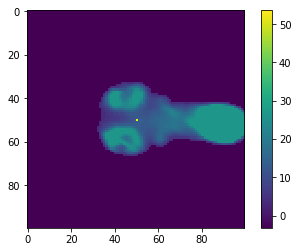

In [49]:
pad = 70
maxThreshold = 30
minThreshold = 7
downsample = lambda x: skimage.transform.resize(x,np.array(firstFrame.shape[:2])/4)
frame = downsample(firstFrame)
frame = np.full([pad*2+frame.shape[0],pad*2+frame.shape[1]], 1)
fishroiframe = downsample(firstFrame)
frame[pad:-pad,pad:-pad] = downsample(denoise_tv_chambolle(frames[11,:,:,0]).copy()*255)
frame[frame>maxThreshold] = maxThreshold
frame[frame<minThreshold] = 0
# plt.imshow(frame)
# plt.colorbar()

# fishCenter = (pad+117,pad+95)
fishCenter = (pad+59,pad+47)
pad = 50

fishROI = ft.selectROI(frame,fishCenter, pad)

# fishROI = normalize(fishROI, norm='l2')
fishROI = fishROI - fishROI.mean()
# fishROI = (fishROI - fishROI.mean())/fishROI.std()
# fishROI = fishROI - fishROI.sum()/len(fishROI)
fishROI = fishROI.astype(float32)

fishROI[pad,pad] = np.max(fishROI)*2
plt.imshow(fishROI)
plt.colorbar()
imageW, imageH = frame.shape

In [50]:
dtype = np.float32
filters = ft.ROI_to_filters(frame, fishCenter, pad, imageW, imageH, 32,dtype=dtype)
filters_fft = ft.ROI_to_filters(frame, fishCenter, pad, imageW, imageH, 32, fft=True)

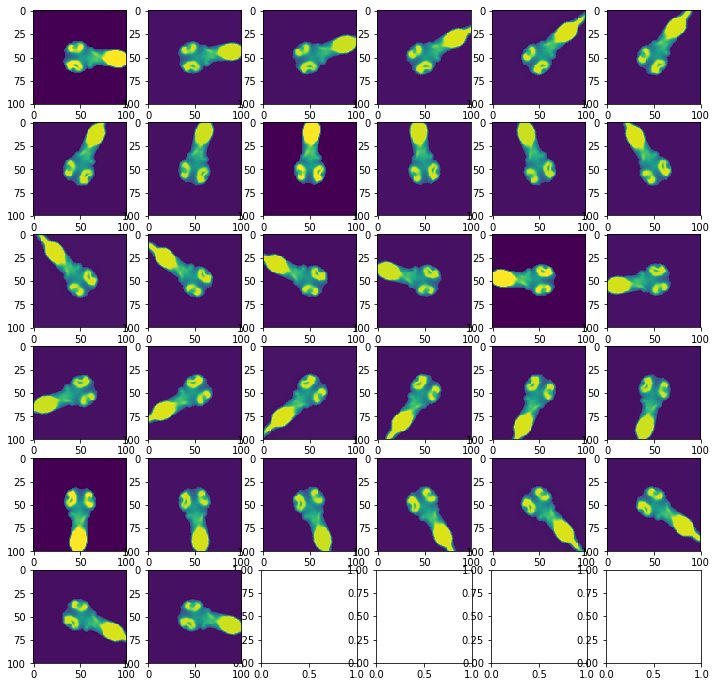

In [51]:
nrow = 6
ncol = 6
plt.subplots(nrow,ncol,figsize=(12,12))
for i in range(filters.shape[0]):
    plt.subplot(nrow,ncol,1+i)
    plt.imshow(filters[i].cpu().numpy().astype(np.float32))

Best: filter=15, x=311, y=361


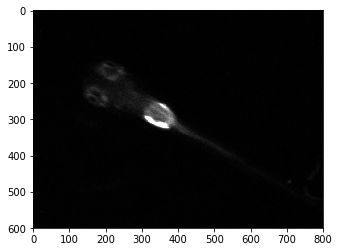

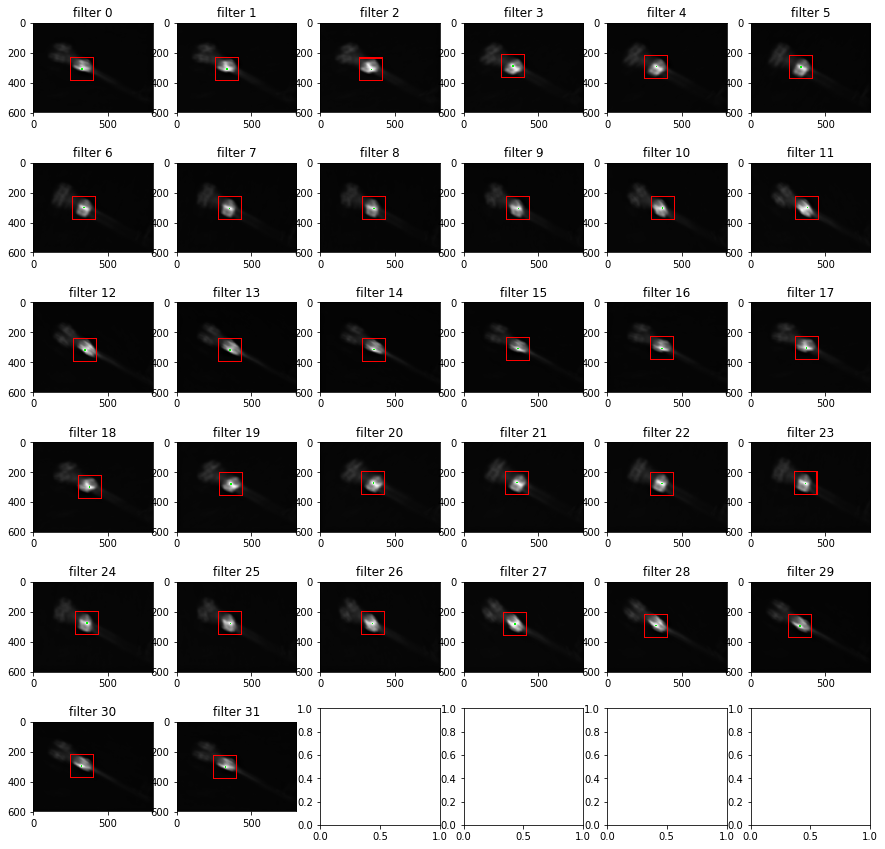

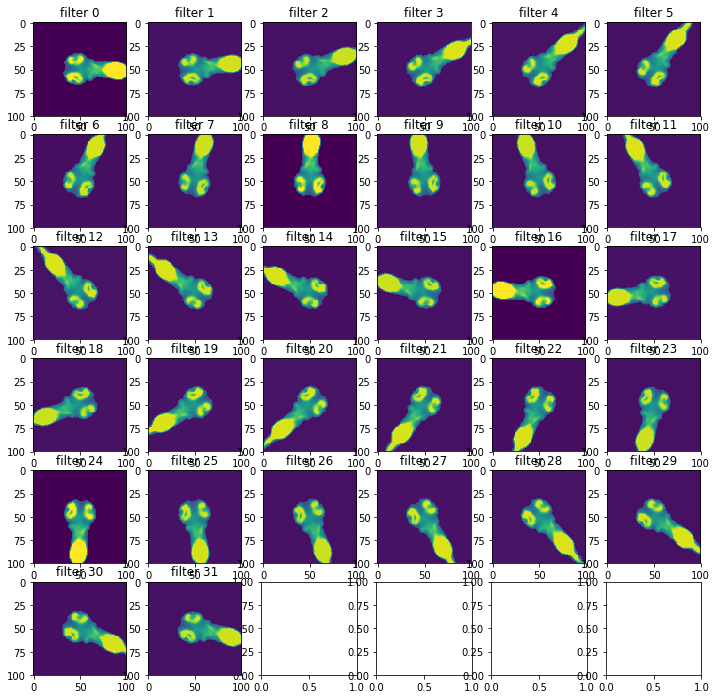

In [52]:
def viz_find_position(img, filters, fft=False,dtype=np.float32):
    nrow = int(np.ceil(np.sqrt(filters.shape[0])))
    ncol = nrow
    plt.imshow(img)
    if fft:
        hm = ft.heatmap_fft(img[:,:,0].astype(dtype),filters)
    else:
        hm = ft.heatmap(img[:,:,0].astype(dtype),filters)
    print("Best: filter={}, x={}, y={}".format(*np.unravel_index(np.argmax(hm),hm.shape)))
    plt.subplots(nrow,ncol,figsize=(15,15))
    for i in range(hm.shape[0]):
        plt.subplot(nrow,ncol,1+i)
        h = hm[i].cpu().numpy().astype(np.float32)
        m = np.unravel_index(np.argmax(h),h.shape)
        image = ft.drawROI(ft.scale_range(h[:,:,None],0,1).repeat(3,2),m[0],m[1],7,80,5,use_float=True)
        plt.imshow(image)
        plt.title("filter {}".format(i))

    plt.subplots(nrow,ncol,figsize=(12,12))
    for i in range(hm.shape[0]):
        plt.subplot(nrow,ncol,1+i)
        f = filters[i].cpu().numpy().astype(np.float32)
        if fft:
            f = f[:,:,0]
        plt.imshow(f)
        plt.title("filter {}".format(i))

viz_find_position(frames[7], filters)

In [53]:
f = frames[0]
img = downsample(f[:,:,0].astype(np.float64)).astype(dtype)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


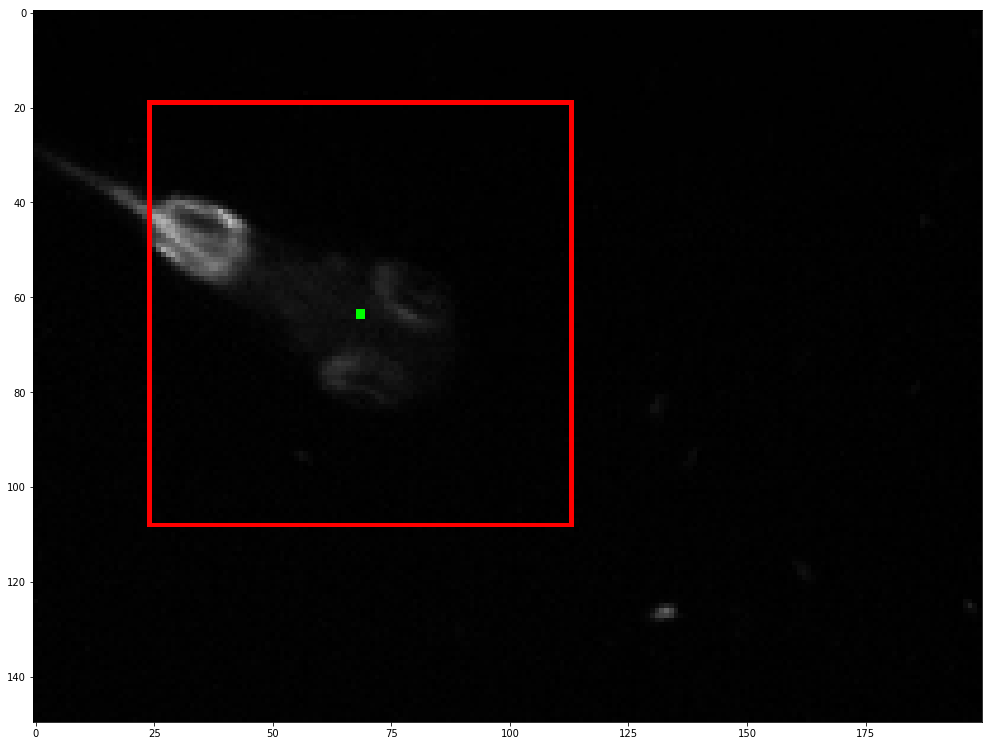

In [54]:
pos = ft.find_position(img,filters)
plt.figure(figsize=(17,17))
plt.imshow(ft.drawROI(downsample(f),*pos,1,45,1))

In [ ]:
ft.write_video(filters, vid_file, directory + "track_close_32filters_" + filename,nframes=1e4,nskip=1e1)

# Benchmarking

In [119]:
%%timeit -r 3 -n 3
pos = heatmap_fft(img,filters_fft,shape)

1.34 ms ± 5.78 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [120]:
%%timeit -r 3 -n 3
# for some reason, pytorch argmax is performing very slowly.
pos = find_position_fft(img,filters_fft,shape)

303 ms ± 4.82 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [35]:
reload(ft)

<module 'fish_track' from '/home/ubuntu/fish_track.py'>

In [36]:
%%timeit -r 3 -n 3
# numpy's argmax is performing much better, but this is suboptimal
# as must transfer entire image back to CPU
pos = ft.find_position_fft_np_argmax(img,filters_fft)

RuntimeError: The expanded size of the tensor (1600) must match the existing size (200) at non-singleton dimension 1

In [64]:
%%timeit -r 3 -n 3
pos = ft.heatmap(img,filters)

29.6 ms ± 4.48 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [30]:
%%timeit -r 3 -n 3
pos = ft.find_position(img,filters)

14.8 ms ± 240 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [18]:
%%timeit -r 3 -n 3
pos = find_position_threshold(img,filters)

873 ms ± 5.94 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [43]:
np.array(img.shape)/2

array([300., 400.])

In [55]:
%%timeit -r 3 -n 3
x = scipy.signal.convolve(img,filters[0])
np.argmax(x)

1.92 ms ± 754 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


# FFT conv validation (failing)

In [38]:
def heatmap_fft(img, w):
    fimg = T.cuda.FloatTensor(*w.shape[1:]).zero_()
    fimg[:,:,0] = T.from_numpy(img).cuda()
    conv = T.ifft(T.fft(fimg,2)*w,2)
    return conv[:,:,:,0]

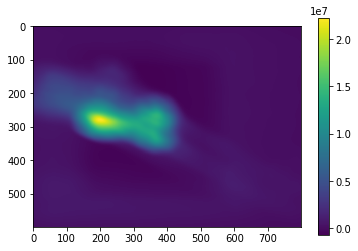

In [17]:
plt.imshow(ft.heatmap(img, filters).cpu().numpy()[0].astype(np.float64))
plt.colorbar()

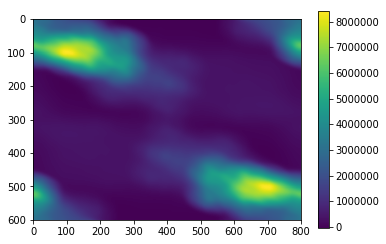

In [39]:
plt.imshow(heatmap_fft(img, filters_fft)[0])
plt.colorbar()

Best: filter=13, x=206, y=146


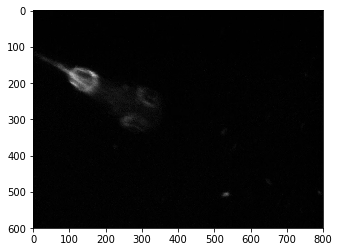

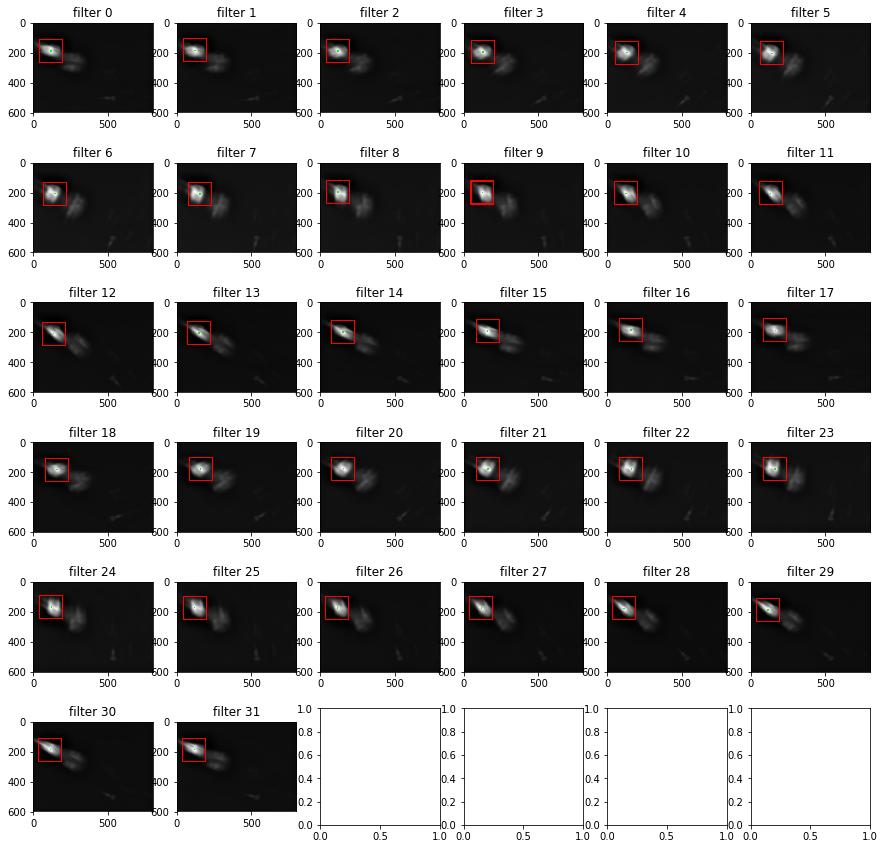

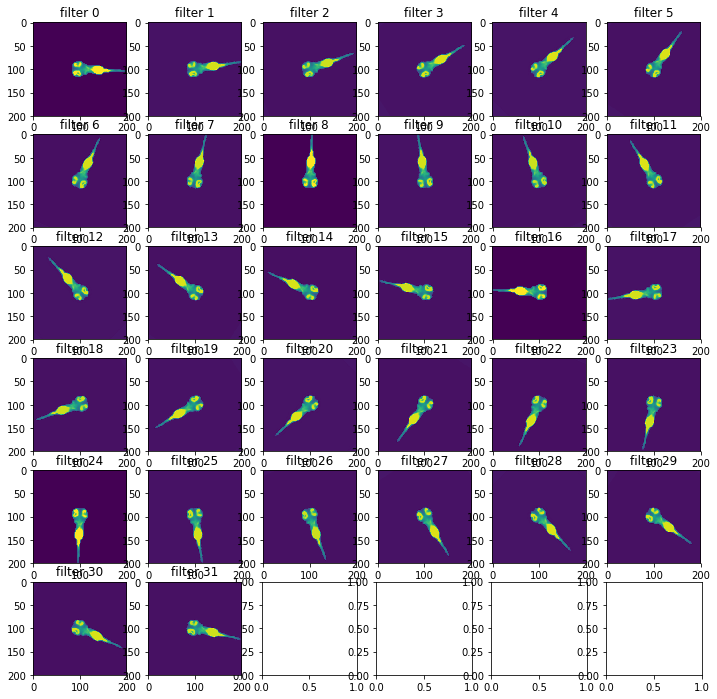

In [46]:
viz_find_position(frames[0], filters)

In [31]:
reload(ft)

<module 'fish_track' from '/home/ubuntu/fish_track.py'>

Best: filter=15, x=14, y=11


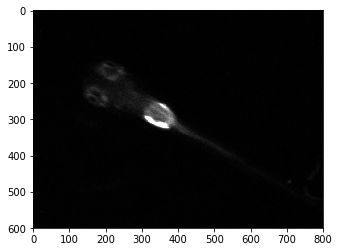

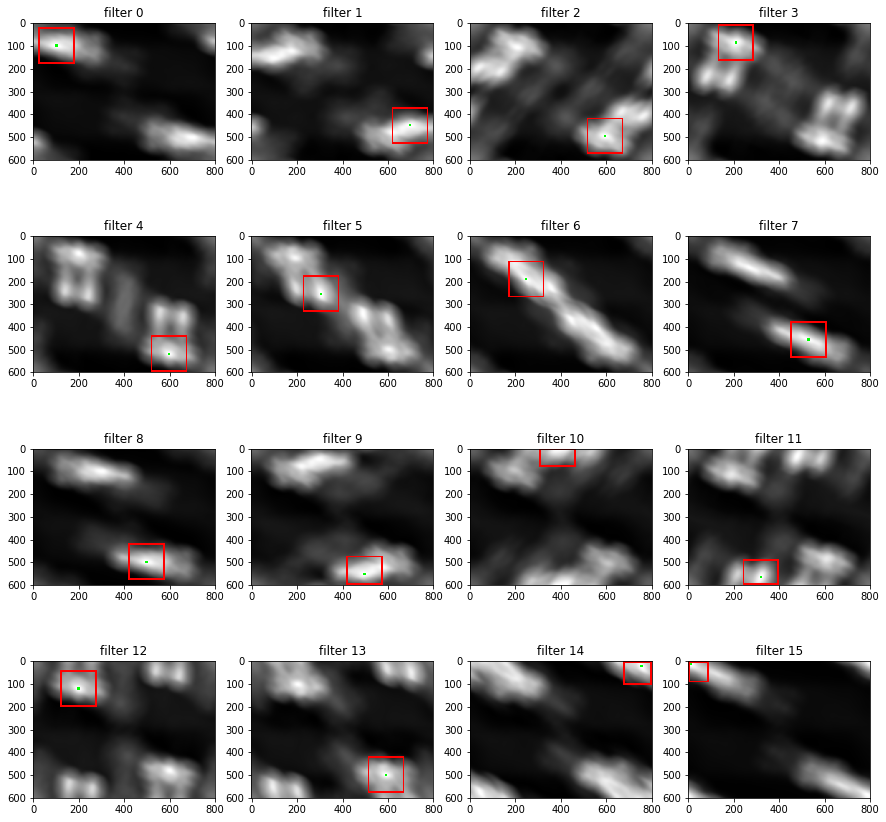

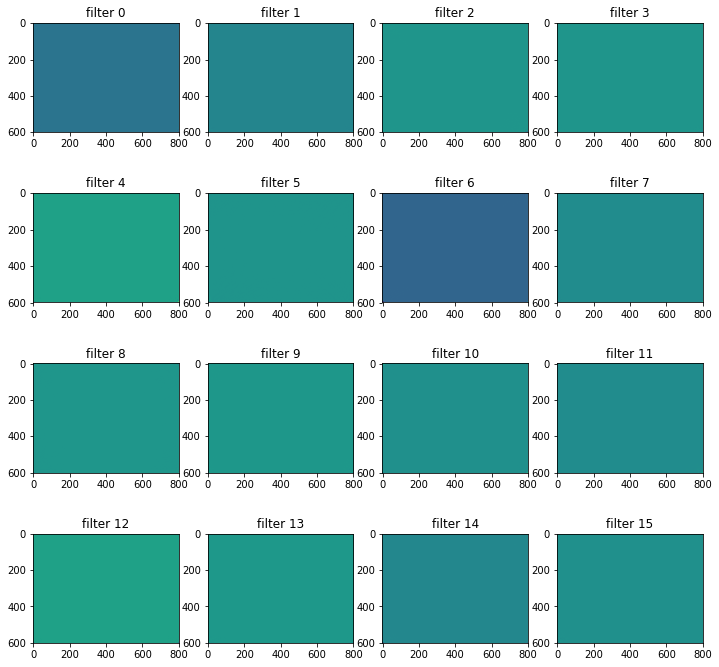

In [35]:
viz_find_position(frames[7], filters_fft, fft=True)

# Create tracking video

In [ ]:
def find_position_scipy(img, w, parallel):
    conv = delayed(lambda i: scipy.signal.convolve(img,w[i]))
    hm = np.array(parallel(conv(i) for i in range(w.shape[0])))
    idx = hm.argmax()
    y, x = np.unravel_index(idx, hm.shape)[1:]
    return y, x

def write_video_scipy(filters, input_vid_filename, output_vid_filename,nframes=1e4,nskip=1e1, downsample=4):
    vid_gen = skvideo.io.vreader(input_vid_filename)
    writer = skvideo.io.FFmpegWriter(output_vid_filename)
    with Parallel(n_jobs=8) as parallel:
        for t, frame in tqdm(enumerate(vid_gen)):
            if t % 10 ==0:
                img = frame[:,:,0].astype(np.float32)
                pos = find_position(img,filters)
                f = drawROI(frame,*pos,2,90,1)
                writer.writeFrame(f)
            if t > 1000*10:
                break
        writer.close()

In [59]:
from joblib import Parallel, delayed

In [64]:
img.shape

(150, 200)

In [69]:
def find_position_scipy(img, w, parallel):
    hm = np.array(parallel(
        delayed(scipy.signal.convolve)(img,w[i])
        for i in range(w.shape[0])))
    idx = hm.argmax()
    y, x = np.unravel_index(idx, hm.shape)[1:]
    return y, x

with Parallel(n_jobs=8) as parallel:
    hm = find_position_scipy(img, filters, parallel)

Process ForkPoolWorker-25:
RuntimeError: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/joblib/pool.py", line 362, in get
    return recv()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 251, in recv
    return _ForkingPickler.loads(buf.getbuffer())
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/cuda/__init__.py", line 

KeyboardInterrupt: 